In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os
import numpy as np
import torch as tc
import torchvision as tv
import pandas as pd
import matplotlib.pyplot as plt
!pip install SimpleITK
import SimpleITK as sitk
from torch.utils.tensorboard import SummaryWriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 23.2 MB/s eta 0:00:00


In [4]:
input_file =  '/content/drive/MyDrive/ColabNotebooks/Lab_8/archive.zip'
output_folder = '/content/drive/MyDrive/ColabNotebooks/Lab_8/'

print(f"Input file path: {input_file}")
print(f"Output folder path: {output_folder}")
# !unzip {input_file} -d {output_folder} # Do this only once, them comment out this command

Input file path: /content/drive/MyDrive/ColabNotebooks/Lab_8/archive.zip
Output folder path: /content/drive/MyDrive/ColabNotebooks/Lab_8/


In [5]:
import os
import pandas as pd
import torch as tc
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt

import os
import pandas as pd
import torch as tc
from torch.utils.data import Dataset
from torchvision import transforms as T
from PIL import Image

class XRayDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path, transform=None):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataframe = pd.read_csv(self.csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        current_case = self.dataframe.iloc[idx]
        current_path = os.path.join(self.dataset_path, current_case['Image Path'])
        current_image = Image.open(current_path).convert('L')  # Convert image to grayscale
        if self.transform:
            current_image = self.transform(current_image)
        return current_image



In [6]:
csv_path = os.path.join(output_folder, "dataset.csv")
data_path = os.path.join(output_folder, "Data")
path_to_training_set = os.path.join(data_path, "train")
path_to_testing_set = os.path.join(data_path, "test")

dataset = []

for root, dirs, files in os.walk(path_to_training_set):
    for file in files:
        if file.endswith(('png', 'jpg', 'jpeg')):
            dataset.append(os.path.join(root, file))

for root, dirs, files in os.walk(path_to_testing_set):
    for file in files:
        if file.endswith(('png', 'jpg', 'jpeg')):
            dataset.append(os.path.join(root, file))

# Create DataFrame and save to .csv file
dataframe = pd.DataFrame(dataset, columns=["Image Path"])
dataframe.to_csv(csv_path, index=False)
print(f"Dataset size: {len(dataframe)}")
print(f"CSV file created at: {csv_path}")

Dataset size: 6432
CSV file created at: /content/drive/MyDrive/ColabNotebooks/Lab_8/dataset.csv


Dataset size: 6432


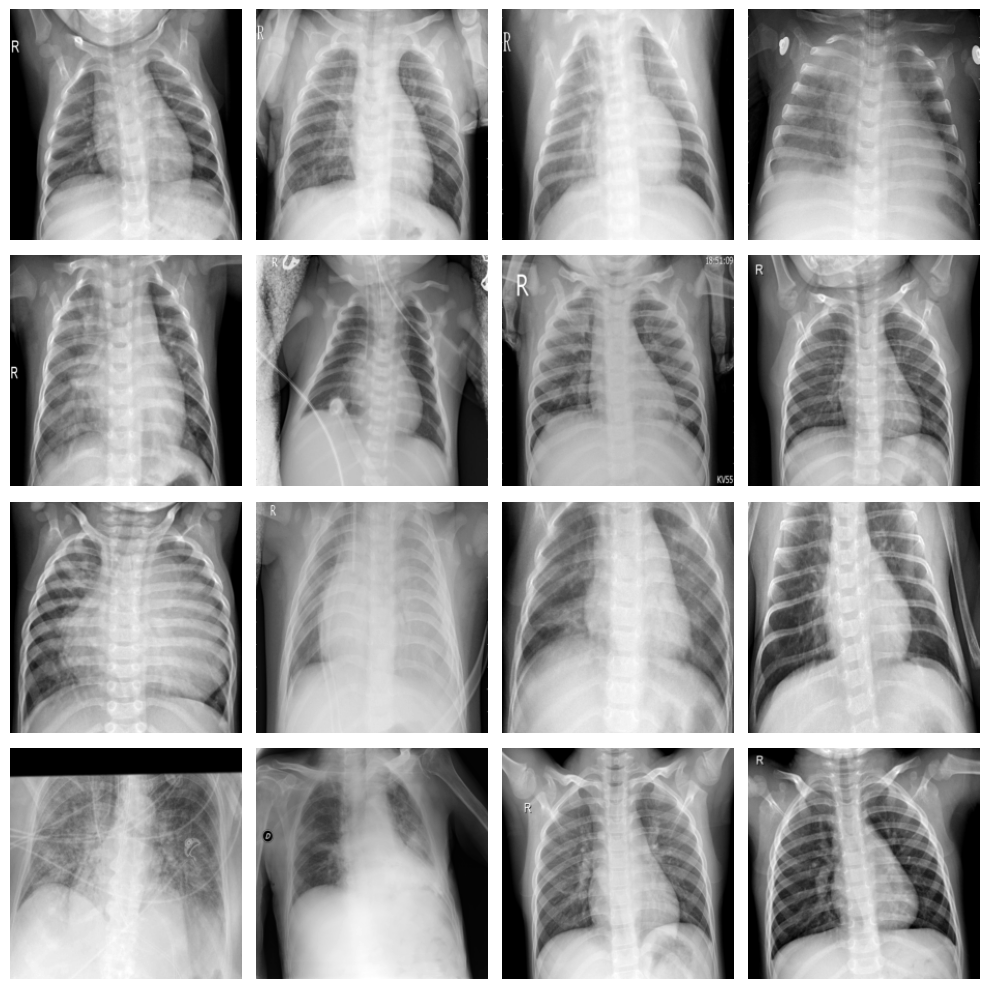

In [7]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
])

batch_size = 16
shuffle = True
dataset = XRayDataset(data_path, csv_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

print(f"Dataset size: {len(dataset)}")
for images in dataloader:

    num_images = len(images)

    fig, axs = plt.subplots(4, 4, figsize=(10, 10))

    for i in range(16):
        row = i // 4
        col = i % 4

        img = images[i]

        img_pil = T.ToPILImage()(img)

        axs[row, col].imshow(img_pil, cmap='gray')
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()
    break

In [ ]:
import torch.nn as nn
import torch

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.05),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.05),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.05),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(1024),
            nn.LeakyReLU(0.05),
            nn.Conv2d(1024, 256, kernel_size=7, stride=1),
            nn.Flatten()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 1024, kernel_size=7, stride=1),
            nn.InstanceNorm2d(1024),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, latent_space):
        latent_space = latent_space.view(latent_space.size(0), 256, 1, 1)
        return self.decoder(latent_space)

    def generate(self, num_samples, device="cpu"):
        latent_space = torch.randn(num_samples, 256).to(device)
        return self.decode(latent_space)

    def forward(self, x):
        latent_space = self.encode(x)
        return self.decode(latent_space)


In [ ]:
ae_model = AutoEncoder()
for images in dataloader:
    output = ae_model(images)
    print(f"Output shape: {output.shape}")
    generated_images = ae_model.generate(images.size(0))
    print(f"Generated images shape: {generated_images.shape}")
    break

Output shape: torch.Size([16, 1, 224, 224])
Generated images shape: torch.Size([16, 1, 224, 224])


In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torch

def training(model, dataloader, reconstruction_function, optimizer, num_epochs, logger, device, log_interval=1):
    writer = SummaryWriter()  # Tensorboard writer

    print(f"Dataset size: {len(dataloader.dataset)}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, images in enumerate(dataloader):
            images = images.to(device)

            # Forward pass
            reconstructed_images = model(images)
            loss = reconstruction_function(reconstructed_images, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        print(f"Current epoch: {epoch}")
        print(f"Current training epoch loss: {epoch_loss:.6f}")

        # Log reconstruction loss to Tensorboard
        writer.add_scalar('Loss/train', epoch_loss, epoch+1)

        # Log exemplary images to Tensorboard every epoch
        if (epoch + 1) % log_interval == 0:
            model.eval()
            with torch.no_grad():
                example_images = next(iter(dataloader))
                example_images = example_images.to(device)
                reconstructed_example_images = model(example_images)
                example_images_grid = torch.cat([example_images[:8], reconstructed_example_images[:8]])
                writer.add_images('Images/Original vs Reconstructed', example_images_grid, global_step=epoch+1)

    writer.close()


In [ ]:
# !pip install tensorboard
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Here 10 epochs were used becuase of lack of free usage for training on GPU offered by Google Colab. Only 3 hours are available. Training for 100 epochs takes 5-6 hours.

In [ ]:
learning_rate = 0.003
device = "cuda:0"
ae_model = AutoEncoder().to(device)  # Move model to GPU
batch_size = 16
num_epochs = 10
parameters = ae_model.parameters()
optimizer = tc.optim.Adam(parameters, lr=learning_rate)
logger = SummaryWriter("/content/logs", comment="AutoEncoder")
reconstruction_function = lambda a, b: tc.mean((a-b)**2)

dataset = XRayDataset(data_path, csv_path, transform=transform)
# Move data loader to GPU if needed
dataloader = tc.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [ ]:
training(ae_model, dataloader, reconstruction_function, optimizer, num_epochs, logger, device)


Dataset size: 6432
Current epoch: 0
Current training epoch loss: 0.043875
Current epoch: 1
Current training epoch loss: 0.018528
Current epoch: 2
Current training epoch loss: 0.011360
Current epoch: 3
Current training epoch loss: 0.007903
Current epoch: 4
Current training epoch loss: 0.006177
Current epoch: 5
Current training epoch loss: 0.005325
Current epoch: 6
Current training epoch loss: 0.004855
Current epoch: 7
Current training epoch loss: 0.004474
Current epoch: 8
Current training epoch loss: 0.004203
Current epoch: 9
Current training epoch loss: 0.003981


Original images shape: torch.Size([16, 1, 224, 224])
Reconstructed images shape: torch.Size([16, 1, 224, 224])


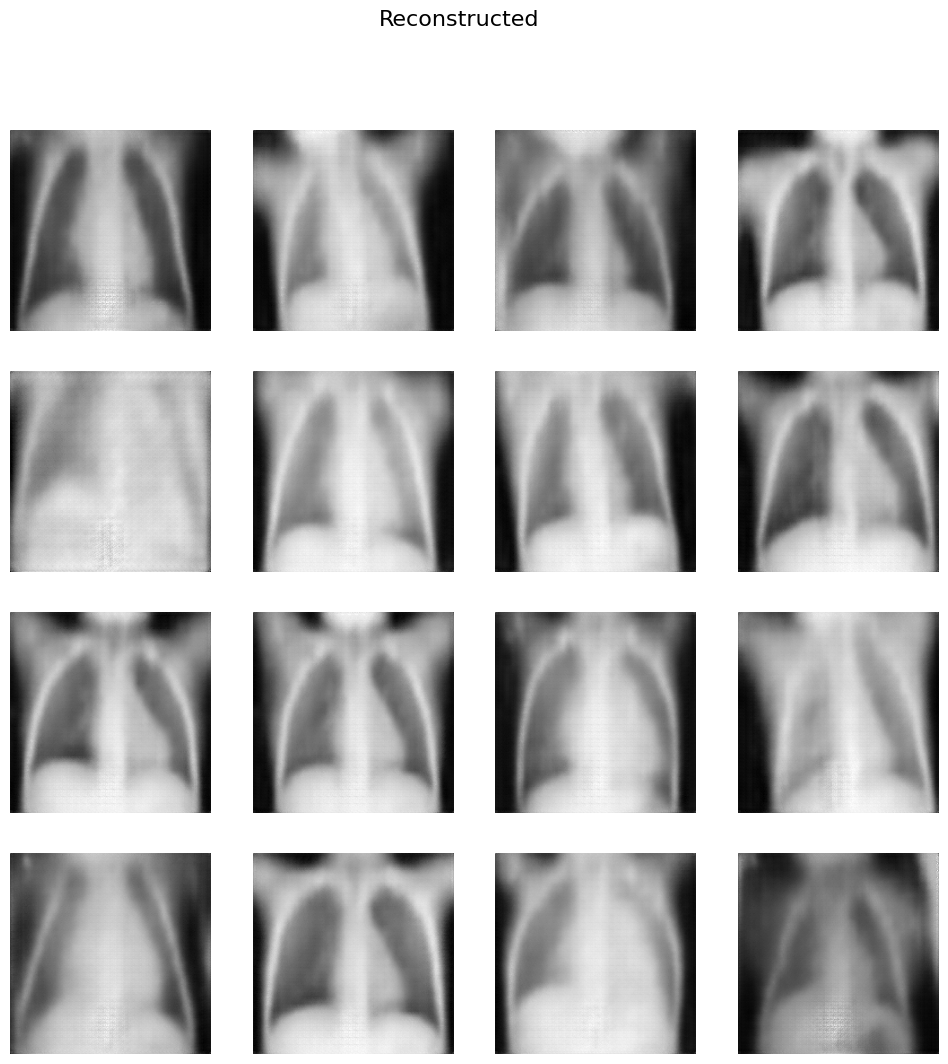

In [ ]:
import matplotlib.pyplot as plt

# Verify the reconstruction ability on the training set
ae_model.eval()
with torch.no_grad():
    for images in dataloader:
        images = images.to(device)
        reconstructed_images = ae_model(images)
        print(f"Original images shape: {images.shape}")
        print(f"Reconstructed images shape: {reconstructed_images.shape}")

        # Plot the first 16 reconstructed images in a 4x4 grid with a single header
        num_images = 16
        fig, axes = plt.subplots(4, 4, figsize=(12, 12))
        fig.suptitle('Reconstructed', fontsize=16)

        for i in range(num_images):
            ax = axes[i // 4, i % 4]
            ax.imshow(reconstructed_images[i].cpu().numpy().squeeze(), cmap='gray')
            ax.axis('off')

        plt.show()
        break  # We only need to visualize one batch


Generated images shape: torch.Size([16, 1, 224, 224])


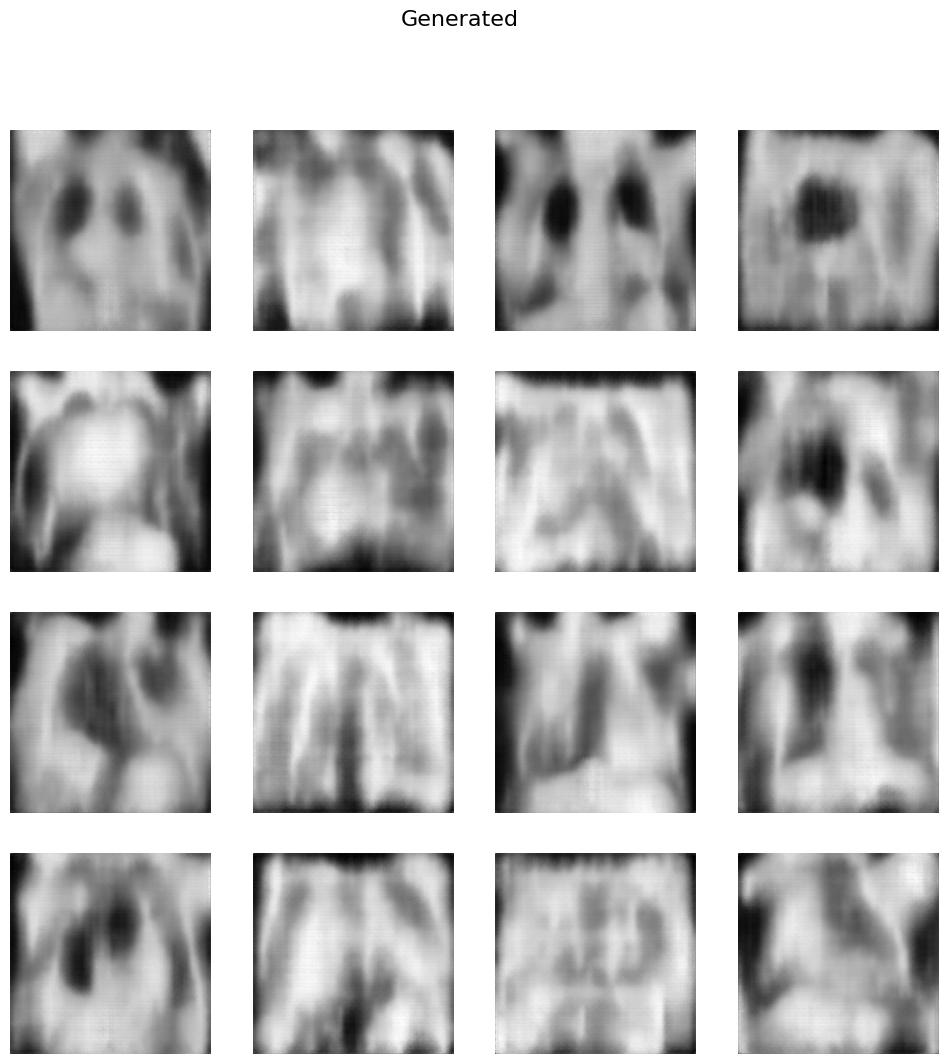

In [ ]:
# Generate new images
num_generated_images = 16
generated_images = ae_model.generate(num_generated_images, device=device)
print(f"Generated images shape: {generated_images.shape}")

# Plot the generated images in a 4x4 grid with a single header
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Generated', fontsize=16)

for i in range(num_generated_images):
    ax = axes[i // 4, i % 4]
    ax.imshow(generated_images[i].detach().cpu().numpy().squeeze(), cmap='gray')
    ax.axis('off')

plt.show()

In [ ]:
from google.colab import drive
import torch

# Mount Google Drive
drive.mount('/content/drive')

# Define the path where you want to save the model
save_path = '/content/drive/MyDrive/ColabNotebooks/Lab_8/autoencoder_model.pth'

# Save the model's state dict
torch.save(ae_model.state_dict(), save_path)

print(f"Model state dict saved to {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model state dict saved to /content/drive/MyDrive/ColabNotebooks/Lab_8/autoencoder_model.pth


In [1]:
import torch.nn as nn
import torch
import torch.distributions as dist

class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.05),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.05),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.05),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(1024),
            nn.LeakyReLU(0.05),
            nn.Conv2d(1024, 256, kernel_size=7, stride=1),
            nn.Flatten()
        )

        # Mean and Log Variance layers
        self.fc_mean = nn.Linear(256, 256)
        self.fc_logvar = nn.Linear(256, 256)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 1024, kernel_size=7, stride=1),
            nn.InstanceNorm2d(1024),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)
        )

    def encode(self, x):
        h = self.encoder(x)
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, latent_space):
        latent_space = latent_space.view(latent_space.size(0), 256, 1, 1)
        return self.decoder(latent_space)

    def generate(self, num_samples, device="cpu"):
        latent_space = torch.randn(num_samples, 256).to(device)
        return self.decode(latent_space)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        recon_x = self.decode(z)
        return recon_x, z, mean, logvar


In [8]:
vae_model = VariationalAutoEncoder()
for images in dataloader:
    output, _, _, _ = vae_model(images)
    print(f"Output shape: {output.shape}")
    generated_images = vae_model.generate(images.size(0))
    print(f"Generated images shape: {generated_images.shape}")
    break

Output shape: torch.Size([16, 1, 224, 224])
Generated images shape: torch.Size([16, 1, 224, 224])


In [10]:
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn.functional as F

def kl_divergence(mean, logvar):
    # KL Divergence between the Gaussian posterior and the prior (standard normal distribution)
    return -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

def training(model, dataloader, reconstruction_function, distribution_function, lambda_distribution,
             optimizer, num_epochs, logger, device, log_interval=1):
    writer = SummaryWriter()  # Tensorboard writer

    print(f"Dataset size: {len(dataloader.dataset)}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_reconstruction_loss = 0.0
        running_kl_loss = 0.0

        for batch_idx, images in enumerate(dataloader):
            images = images.to(device)

            # Forward pass
            reconstructed_images, z, mean, logvar = model(images)

            # Calculate the reconstruction loss
            reconstruction_loss = reconstruction_function(reconstructed_images, images)

            # Calculate the KL divergence
            kl_loss = distribution_function(mean, logvar)

            # Total loss
            loss = reconstruction_loss + lambda_distribution * kl_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_reconstruction_loss += reconstruction_loss.item()
            running_kl_loss += kl_loss.item()

        epoch_loss = running_loss / len(dataloader)
        epoch_reconstruction_loss = running_reconstruction_loss / len(dataloader)
        epoch_kl_loss = running_kl_loss / len(dataloader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}, "
              f"Reconstruction Loss: {epoch_reconstruction_loss:.6f}, KL Loss: {epoch_kl_loss:.6f}")

        # Log losses to Tensorboard
        writer.add_scalar('Loss/Total', epoch_loss, epoch+1)
        writer.add_scalar('Loss/Reconstruction', epoch_reconstruction_loss, epoch+1)
        writer.add_scalar('Loss/KL_Divergence', epoch_kl_loss, epoch+1)

        # Log exemplary images to Tensorboard every log_interval epochs
        if (epoch + 1) % log_interval == 0:
            model.eval()
            with torch.no_grad():
                example_images = next(iter(dataloader))
                example_images = example_images.to(device)
                reconstructed_example_images, _, _, _ = model(example_images)
                example_images_grid = torch.cat([example_images[:8], reconstructed_example_images[:8]])
                writer.add_images('Images/Original vs Reconstructed', example_images_grid, global_step=epoch+1)

    writer.close()

In [12]:
learning_rate = 0.003
vae_model = VariationalAutoEncoder()
batch_size = 16
num_epochs = 100
parameters = vae_model.parameters()
optimizer = tc.optim.Adam(parameters, lr=learning_rate)
device = "cuda:0"
logger = SummaryWriter("/content/logs/VAE", comment="VariationalAutoEncoder")
reconstruction_function = lambda a, b: tc.mean((a-b)**2)
distribution_function = kl_divergence
lambda_distribution = 0.003

dataset = XRayDataset(data_path, csv_path, transform=transform)
dataloader = tc.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Faced with such problem:
ValueError: Expected parameter loc (Tensor of shape (16, 256)) of distribution Normal(loc: torch.Size([16, 256]), scale: torch.Size([16, 256])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward0>)